In [1]:
"""
Predictive Maintenance of Industrial Machines

This script performs an end-to-end machine learning project aimed at
predicting potential failures in industrial machines based on sensor data.
It covers data loading, cleaning, exploratory data analysis (EDA),
feature engineering, preprocessing, model training (evaluating multiple
classifiers), imbalance handling (SMOTE), model evaluation, and saving
the best-performing model for deployment.

The primary goal is to identify different types of machine failures
(e.g., tool wear, heat dissipation) to enable proactive maintenance,
thereby reducing downtime and operational costs.
"""

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import configparser # For reading configuration file
import joblib

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # SimpleImputer might be needed if NaNs aren't handled before pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, # accuracy_score removed as it's part of classification_report
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# --- CONFIGURATION (Loaded from config.ini) ---
config = configparser.ConfigParser()
config.read('config.ini') # Make sure config.ini is in the same directory

['config.ini']

In [6]:
# Paths
DATA_FILE_PATH = config.get('Paths', 'DATA_FILE_PATH')
MODEL_PATH = config.get('Paths', 'MODEL_PATH')
# Kept for consistency, though less critical if full pipeline is saved
PREPROCESSOR_PATH = config.get('Paths', 'PREPROCESSOR_PATH')

In [7]:
# Column Names
OPERATIONAL_HOURS_COLUMN_NAME = config.get('ColumnNames', 'OPERATIONAL_HOURS_COLUMN_NAME')
FAILURE_TYPE_COLUMN_NAME = config.get('ColumnNames', 'FAILURE_TYPE_COLUMN_NAME')

In [8]:
# Raw Features (parsed from comma-separated strings)
# Helper function to parse comma-separated strings from config into lists
def parse_list_from_config(config_string):
    return [item.strip() for item in config_string.split(',') if item.strip()]

In [9]:
NUMERICAL_FEATURES_RAW_STR = config.get('Features', 'NUMERICAL_FEATURES_RAW_STR')
# Ensure Operational Hours from ColumnNames is included if not explicitly in the string
# or if the config string is the source of truth.
# For simplicity, we assume the config string NUMERICAL_FEATURES_RAW_STR is complete.
NUMERICAL_FEATURES_RAW = parse_list_from_config(NUMERICAL_FEATURES_RAW_STR)
# Manual check/addition for Operational Hours if it needs special handling:
# if OPERATIONAL_HOURS_COLUMN_NAME not in NUMERICAL_FEATURES_RAW:
# NUMERICAL_FEATURES_RAW.append(OPERATIONAL_HOURS_COLUMN_NAME)


CATEGORICAL_FEATURES_RAW_STR = config.get('Features', 'CATEGORICAL_FEATURES_RAW_STR')
CATEGORICAL_FEATURES_RAW = parse_list_from_config(CATEGORICAL_FEATURES_RAW_STR)

In [10]:
# Engineered Features
FEATURE_TEMP_DIFF = config.get('Features', 'FEATURE_TEMP_DIFF')
FEATURE_MECH_POWER = config.get('Features', 'FEATURE_MECH_POWER')

In [11]:
# Processed Target Column Name
TARGET_COLUMN_PROCESSED = config.get('Features', 'TARGET_COLUMN_PROCESSED')

In [12]:
# Original COL_NAMES (if needed for CSVs without headers - handle manually as it's a specific use case)
# Example: if csv_has_no_headers: df = pd.read_csv(DATA_FILE_PATH, names=ORIGINAL_COL_NAMES_LIST_FROM_NOTEBOOK)
# For now, assuming CSV has headers.

print("Configuration loaded from config.ini.")

Configuration loaded from config.ini.


In [13]:
# 2. Load Data
df = pd.read_csv(DATA_FILE_PATH)

print("Original DataFrame head:")
print(df.head())
print("\nDataFrame Info (before any processing):")
df.info()
print("\nMissing values (before any processing):")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())
# df.drop_duplicates(inplace=True) # Retaining this as an explicit optional step user might want

Original DataFrame head:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Vibration Levels   Operational Hours  \
0                    1551         42.8               42.0               20.0   
1                    1408         46.3               52.0               21.0   
2                    1498         49.4               44.0               18.0   
3                    1433         39.5               52.0               10.0   
4                    1408         40.0               44.0               10.0   

  Failure Type  
0   No Failure  
1   No Failure  
2   No Fai

In [14]:
# 3. Data Cleaning & Basic Pre-computation
if FAILURE_TYPE_COLUMN_NAME not in df.columns:
    raise KeyError(f"Target column '{FAILURE_TYPE_COLUMN_NAME}' not found in DataFrame. Check CSV headers or config.ini.")
if OPERATIONAL_HOURS_COLUMN_NAME not in df.columns:
    raise KeyError(f"Feature column '{OPERATIONAL_HOURS_COLUMN_NAME}' not found in DataFrame. Check CSV headers or config.ini.")

df[TARGET_COLUMN_PROCESSED] = df[FAILURE_TYPE_COLUMN_NAME]
# df[TARGET_COLUMN_PROCESSED] = df[TARGET_COLUMN_PROCESSED].str.strip().str.lower() # Example cleaning

df[OPERATIONAL_HOURS_COLUMN_NAME] = pd.to_numeric(df[OPERATIONAL_HOURS_COLUMN_NAME], errors='coerce')
if df[OPERATIONAL_HOURS_COLUMN_NAME].isnull().any():
    num_nans = df[OPERATIONAL_HOURS_COLUMN_NAME].isnull().sum()
    print(f"Warning: {num_nans} values in '{OPERATIONAL_HOURS_COLUMN_NAME}' could not be converted to numeric and became NaN.")
    # Decision on handling NaNs here is dataset-specific and crucial.
    # For now, they are passed through; subsequent steps might need an imputer or explicit drop.

print("\n--- After basic data type assignments ---")
print(f"Value counts for new target '{TARGET_COLUMN_PROCESSED}':")
print(df[TARGET_COLUMN_PROCESSED].value_counts())
print(f"\nInfo for feature '{OPERATIONAL_HOURS_COLUMN_NAME}':")
print(df[OPERATIONAL_HOURS_COLUMN_NAME].describe())
print(f"Check for NaNs in '{OPERATIONAL_HOURS_COLUMN_NAME}': {df[OPERATIONAL_HOURS_COLUMN_NAME].isnull().sum()}")
print(f"Check for NaNs in '{TARGET_COLUMN_PROCESSED}': {df[TARGET_COLUMN_PROCESSED].isnull().sum()}")

columns_to_drop = ['UDI', 'Product ID']
if FAILURE_TYPE_COLUMN_NAME in df.columns and FAILURE_TYPE_COLUMN_NAME != TARGET_COLUMN_PROCESSED:
     columns_to_drop.append(FAILURE_TYPE_COLUMN_NAME)

columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]
if columns_to_drop_existing:
    df.drop(columns=columns_to_drop_existing, inplace=True)
    print(f"\nDropped columns: {columns_to_drop_existing}")

print("\nDataFrame head after initial cleaning and drops:")
print(df.head())
print("\nDataFrame Info after initial cleaning:")
df.info()


--- After basic data type assignments ---
Value counts for new target 'Failure_Category_Processed':
Failure_Category_Processed
No Failure            467
Tool Wear Failure      19
Overstrain Failure      8
Power Failure           6
Name: count, dtype: int64

Info for feature 'Operational Hours':
count    500.000000
mean      81.106840
std       45.904853
min       10.000000
25%       36.202500
50%       77.575000
75%      121.097500
max      165.330000
Name: Operational Hours, dtype: float64
Check for NaNs in 'Operational Hours': 0
Check for NaNs in 'Failure_Category_Processed': 0

Dropped columns: ['UDI', 'Product ID', 'Failure Type']

DataFrame head after initial cleaning and drops:
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5              

In [15]:
# 4. Feature Engineering
temp_cols_exist = 'Process_temperature_K' in df.columns and 'Air_temperature_K' in df.columns
power_cols_exist = 'Torque_Nm' in df.columns and 'Rotational_speed_rpm' in df.columns

if temp_cols_exist:
    df[FEATURE_TEMP_DIFF] = df['Process_temperature_K'] - df['Air_temperature_K']
else:
    print(f"Warning: Columns for '{FEATURE_TEMP_DIFF}' calculation not found. Skipping this feature.")

if power_cols_exist:
    df[FEATURE_MECH_POWER] = np.round((df['Torque_Nm'] * df['Rotational_speed_rpm'] * 2 * np.pi) / 60, 4)
else:
    print(f"Warning: Columns for '{FEATURE_MECH_POWER}' calculation not found. Skipping this feature.")

print("\nDataFrame head after feature engineering:")
print(df.head())
print("\nDataFrame describe after feature engineering:")
print(df.describe().T)


DataFrame head after feature engineering:
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Vibration Levels   Operational Hours  \
0         42.8               42.0               20.0   
1         46.3               52.0               21.0   
2         49.4               44.0               18.0   
3         39.5               52.0               10.0   
4         40.0               44.0               10.0   

  Failure_Category_Processed  
0                 No Failure  
1                 No Failure  
2                 No Failure  
3              


--- EDA ---


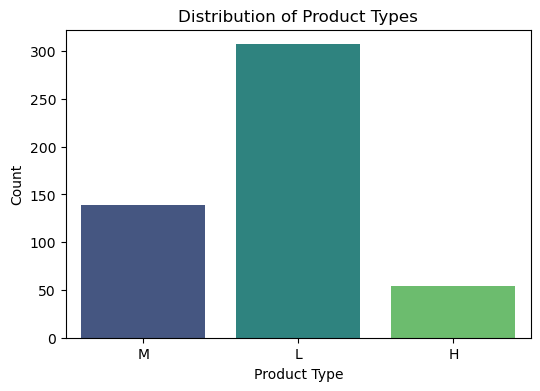

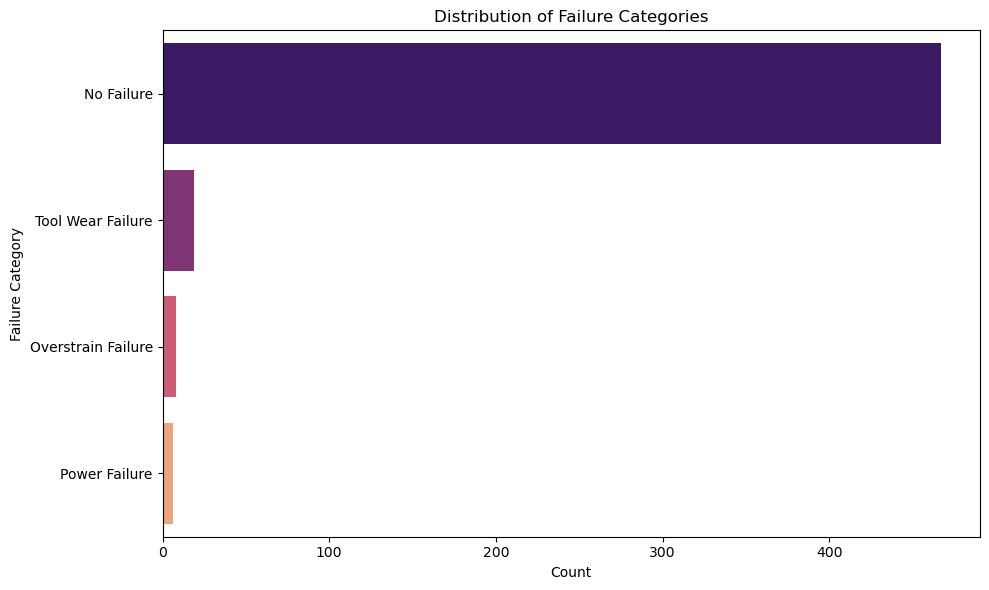


Target variable 'Failure_Category_Processed' distribution:
 Failure_Category_Processed
No Failure            93.4
Tool Wear Failure      3.8
Overstrain Failure     1.6
Power Failure          1.2
Name: proportion, dtype: float64


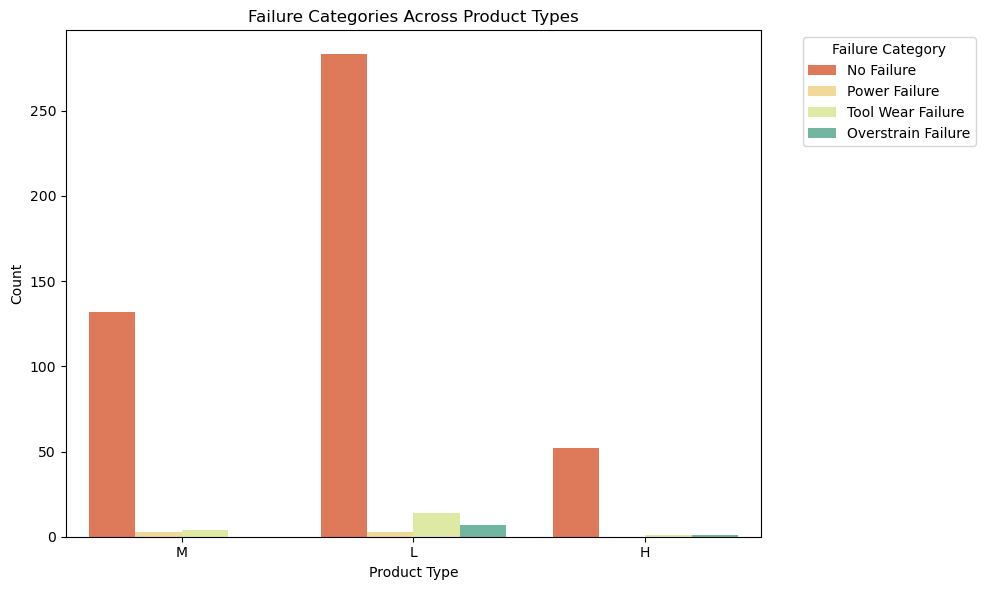


Numerical features for EDA distributions: ['Operational Hours']


In [16]:
# 5. Exploratory Data Analysis (EDA)
print("\n--- EDA ---")

if 'Type' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Type', data=df, palette='viridis')
    plt.title('Distribution of Product Types')
    plt.xlabel('Product Type')
    plt.ylabel('Count')
    plt.show()
else:
    print("Column 'Type' not found for EDA.")

if TARGET_COLUMN_PROCESSED in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=TARGET_COLUMN_PROCESSED, data=df, order=df[TARGET_COLUMN_PROCESSED].value_counts().index, palette='magma')
    plt.title('Distribution of Failure Categories')
    plt.xlabel('Count')
    plt.ylabel('Failure Category')
    plt.tight_layout()
    plt.show()
    print(f"\nTarget variable '{TARGET_COLUMN_PROCESSED}' distribution:\n", df[TARGET_COLUMN_PROCESSED].value_counts(normalize=True) * 100)
else:
    print(f"Target column '{TARGET_COLUMN_PROCESSED}' not found for EDA.")

if 'Type' in df.columns and TARGET_COLUMN_PROCESSED in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Type', hue=TARGET_COLUMN_PROCESSED, data=df, palette='Spectral')
    plt.title('Failure Categories Across Product Types')
    plt.xlabel('Product Type')
    plt.ylabel('Count')
    plt.legend(title='Failure Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print(f"Columns 'Type' or '{TARGET_COLUMN_PROCESSED}' not found for 'Failure Categories Across Product Types' plot.")

numerical_features_for_eda = NUMERICAL_FEATURES_RAW[:]
if FEATURE_TEMP_DIFF in df.columns:
    numerical_features_for_eda.append(FEATURE_TEMP_DIFF)
if FEATURE_MECH_POWER in df.columns:
    numerical_features_for_eda.append(FEATURE_MECH_POWER)

numerical_features_for_eda = [col for col in numerical_features_for_eda if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
print(f"\nNumerical features for EDA distributions: {numerical_features_for_eda}")

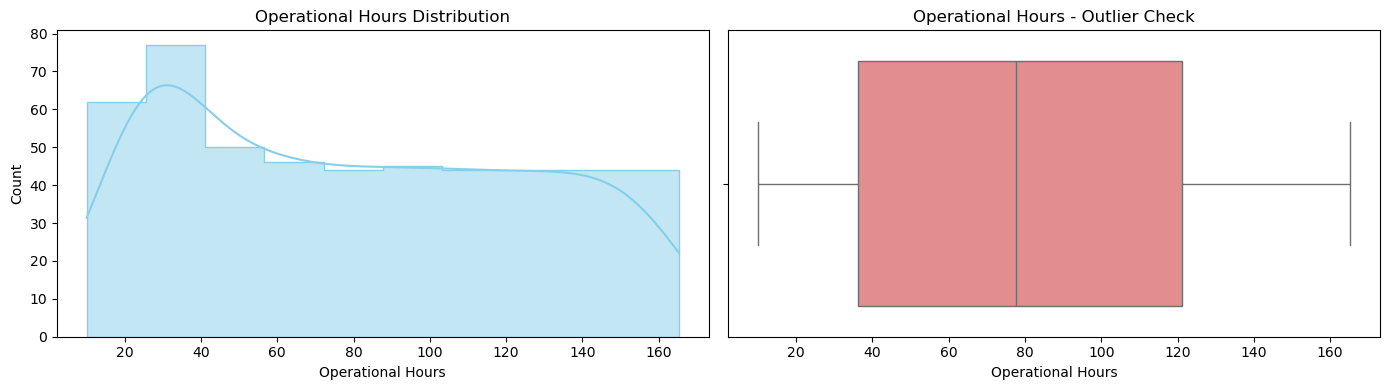

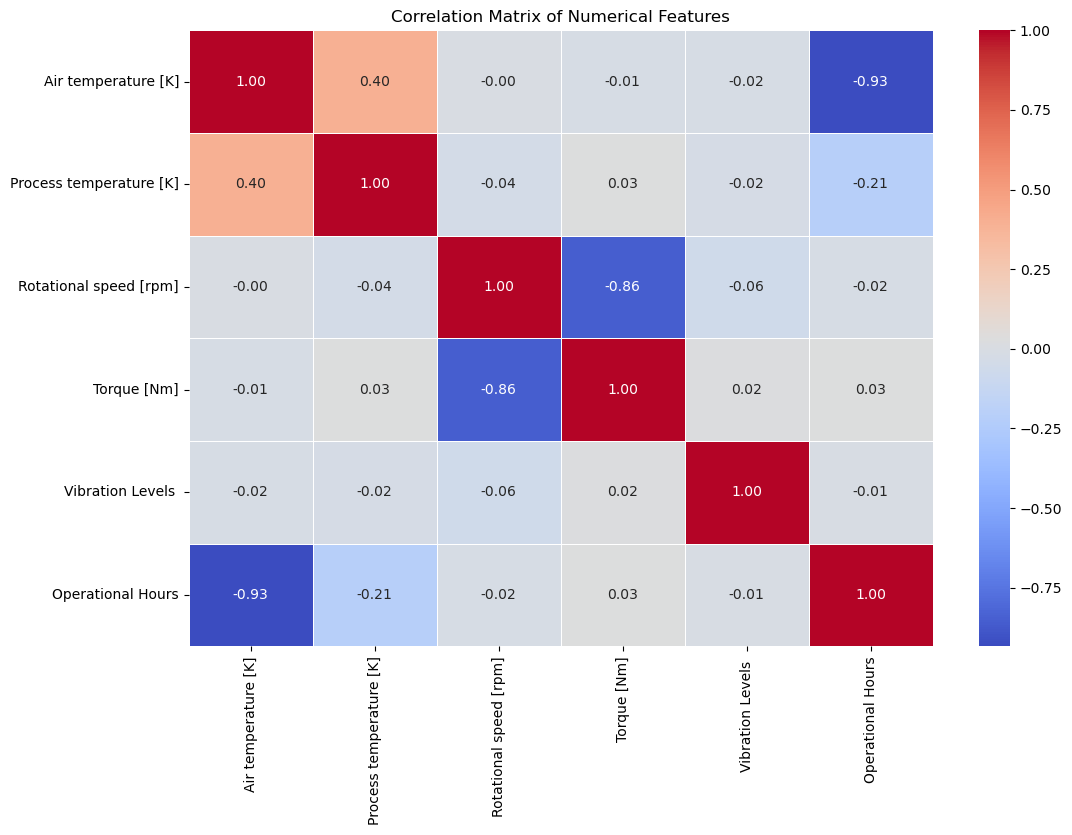

In [17]:
for col in numerical_features_for_eda:
    if df[col].isnull().sum() > 0:
        print(f"Skipping distribution plot for '{col}' due to NaNs. Consider handling them first (e.g., imputation).")
        continue
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', element="step")
    axes[0].set_title(f"{col} Distribution")
    sns.boxplot(data=df, x=col, ax=axes[1], color='lightcoral')
    axes[1].set_title(f"{col} - Outlier Check")
    plt.tight_layout()
    plt.show()

numeric_df_for_corr = df.select_dtypes(include=np.number)
if not numeric_df_for_corr.empty:
    plt.figure(figsize=(12, 8))
    corr_matrix = numeric_df_for_corr.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("No numerical features found for correlation heatmap.")

In [18]:
# 6. Data Preprocessing for Modeling
ALL_NUMERICAL_FEATURES = NUMERICAL_FEATURES_RAW[:]
if FEATURE_TEMP_DIFF in df.columns:
    ALL_NUMERICAL_FEATURES.append(FEATURE_TEMP_DIFF)
if FEATURE_MECH_POWER in df.columns:
    ALL_NUMERICAL_FEATURES.append(FEATURE_MECH_POWER)

ALL_NUMERICAL_FEATURES = [col for col in ALL_NUMERICAL_FEATURES if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
ALL_CATEGORICAL_FEATURES = [col for col in CATEGORICAL_FEATURES_RAW if col in df.columns]

print(f"\nSelected Numerical Features for Model: {ALL_NUMERICAL_FEATURES}")
print(f"Selected Categorical Features for Model: {ALL_CATEGORICAL_FEATURES}")

# Explicitly handle NaNs before splitting if they are present.
# Options:
# 1. Impute (e.g., df[col].fillna(df[col].median(), inplace=True) for numerical)
# 2. Drop rows (df.dropna(subset=ALL_NUMERICAL_FEATURES + ALL_CATEGORICAL_FEATURES + [TARGET_COLUMN_PROCESSED], inplace=True))
# Current approach: Let the pipeline handle NaNs if an imputer is added, or fail if not.
# It's generally better to handle NaNs before train_test_split or ensure the pipeline does.
# For this iteration, we'll assume NaNs in features would need an imputer in the numerical_transformer.
# If `OPERATIONAL_HOURS_COLUMN_NAME` had NaNs from conversion and they were not filled,
# they will persist here. Add SimpleImputer to numerical_transformer if needed.

if TARGET_COLUMN_PROCESSED not in df.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN_PROCESSED}' not found in DataFrame. Check Cell 3 or config.ini.")
if not ALL_NUMERICAL_FEATURES and not ALL_CATEGORICAL_FEATURES:
    raise ValueError("No features selected for modeling. Check feature lists in config.ini and DataFrame columns.")

X = df[ALL_NUMERICAL_FEATURES + ALL_CATEGORICAL_FEATURES]
y = df[TARGET_COLUMN_PROCESSED]

if y.isnull().any():
    print(f"Warning: Target column '{TARGET_COLUMN_PROCESSED}' contains NaNs. Dropping these rows.")
    nan_target_indices = y[y.isnull()].index
    X = X.drop(index=nan_target_indices)
    y = y.drop(index=nan_target_indices)
    print(f"Dropped {len(nan_target_indices)} rows due to NaN in target.")

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())
print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

if y.empty:
    raise ValueError("Target variable 'y' is empty. Cannot proceed. Check data loading and preprocessing.")

print("\nClass distribution in y before split:")
print(y.value_counts(normalize=True) * 100)

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
    )
except ValueError as e:
    print(f"Could not stratify due to: {e}. Splitting without stratification.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print("\n--- Shapes after split ---")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True) * 100)

if X_train.empty or y_train.empty:
    raise ValueError("Training data is empty. Check previous steps for data loss.")

# Add from sklearn.impute import SimpleImputer if using it
numerical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')), # Uncomment if NaNs are expected in numerical features
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')), # Uncomment if NaNs are expected in categorical features
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

active_numerical_features = [col for col in ALL_NUMERICAL_FEATURES if col in X_train.columns]
active_categorical_features = [col for col in ALL_CATEGORICAL_FEATURES if col in X_train.columns]

if not active_numerical_features and not active_categorical_features:
    raise ValueError("No active numerical or categorical features found for the preprocessor.")

transformers_list = []
if active_numerical_features:
    transformers_list.append(('num', numerical_transformer, active_numerical_features))
if active_categorical_features:
    transformers_list.append(('cat', categorical_transformer, active_categorical_features))

if not transformers_list:
    raise ValueError("No transformers could be created.")

preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='drop'
)
print("\nPreprocessor structure:")
print(preprocessor)




Selected Numerical Features for Model: ['Operational Hours']
Selected Categorical Features for Model: ['Type']

Features (X) head:
   Operational Hours Type
0               20.0    M
1               21.0    L
2               18.0    L
3               10.0    L
4               10.0    L

Target (y) head:
0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
Name: Failure_Category_Processed, dtype: object

Shape of X: (500, 2)
Shape of y: (500,)

Class distribution in y before split:
Failure_Category_Processed
No Failure            93.4
Tool Wear Failure      3.8
Overstrain Failure     1.6
Power Failure          1.2
Name: proportion, dtype: float64

--- Shapes after split ---
X_train shape: (400, 2)
X_test shape: (100, 2)
y_train shape: (400,)
y_test shape: (100,)

Class distribution in y_train:
Failure_Category_Processed
No Failure            93.50
Tool Wear Failure      3.75
Overstrain Failure     1.50
Power Failure          1.25
Name: proportion, dtype: floa

In [19]:
# 7. Handling Imbalance
print("\nClass distribution in y_train BEFORE SMOTE:")
print(Counter(y_train))


Class distribution in y_train BEFORE SMOTE:
Counter({'No Failure': 374, 'Tool Wear Failure': 15, 'Overstrain Failure': 6, 'Power Failure': 5})


In [20]:
# 8. Model Training & Evaluation
models_to_evaluate = {
    'Logistic Regression': LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    # 'SVC': SVC(probability=True, random_state=42, class_weight='balanced'), # Can be slow
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3)
}

results_summary = {}
best_model_name = None
best_model_pipeline = None
best_macro_f1 = 0.0

y_train_counts = Counter(y_train)
min_class_count = min(y_train_counts.values()) if y_train_counts else 0
smote_k_neighbors = max(1, min_class_count - 1) if min_class_count > 1 else 1

print(f"\nTraining models. Minimum class count in y_train: {min_class_count}. SMOTE k_neighbors: {smote_k_neighbors}")

use_smote = min_class_count > smote_k_neighbors and min_class_count > 1
if not use_smote:
    print(f"SMOTE will be skipped due to insufficient samples in minority classes (min_class_count={min_class_count}, k_neighbors={smote_k_neighbors}).")
    print("Consider using class_weight in models or collecting more data for minority classes.")

for name, model in models_to_evaluate.items():
    print(f"\n--- Training {name} ---")
    pipeline_steps = [('preprocessor', preprocessor)]

    if use_smote and name not in ['Random Forest', 'Gradient Boosting']: # Example: Skip SMOTE for these
        pipeline_steps.append(('smote', SMOTE(random_state=42, k_neighbors=smote_k_neighbors)))
        print(f"Using SMOTE for {name}.")
    elif hasattr(model, 'class_weight') and model.get_params().get('class_weight'):
        print(f"Model {name} has 'class_weight'. SMOTE not applied by default, relying on class_weight.")
    else:
        print(f"SMOTE not applied for {name} based on current conditions/model type.")

    pipeline_steps.append(('classifier', model))
    full_pipeline = ImbPipeline(steps=pipeline_steps)

    try:
        full_pipeline.fit(X_train, y_train)
        y_pred_test = full_pipeline.predict(X_test)
        report = classification_report(y_test, y_pred_test, zero_division=0, output_dict=True)
        accuracy_val = report['accuracy']
        macro_f1_score = report['macro avg']['f1-score']

        print(f"{name} Test Accuracy: {accuracy_val:.4f}")
        print(f"{name} Test Macro F1-Score: {macro_f1_score:.4f}")

        results_summary[name] = {'accuracy': accuracy_val, 'macro_f1': macro_f1_score, 'pipeline': full_pipeline, 'report': report}

        if macro_f1_score > best_macro_f1:
            best_macro_f1 = macro_f1_score
            best_model_name = name
            best_model_pipeline = full_pipeline

    except ValueError as e:
        print(f"ERROR training {name}: {e}")
        results_summary[name] = {'accuracy': 0, 'macro_f1': 0, 'pipeline': None, 'report': None, 'error': str(e)}

print("\n--- Model Evaluation Summary ---")
if not results_summary:
    print("No models were successfully trained.")
else:
    for name, metrics in results_summary.items():
        if metrics.get('error'):
            print(f"{name}: Error - {metrics['error']}")
        else:
            print(f"{name}: Accuracy = {metrics['accuracy']:.4f}, Macro F1 = {metrics['macro_f1']:.4f}")

    if best_model_name:
        print(f"\nBest performing model (based on Macro F1): {best_model_name} with Macro F1: {best_macro_f1:.4f}")
    else:
        print("\nNo model was successfully selected as best.")

final_model_pipeline = best_model_pipeline
chosen_model_name = best_model_name

if not final_model_pipeline:
    print("\nWarning: No best model selected. Attempting to train a default Random Forest as a fallback.")
    try:
        rf_fallback_model = RandomForestClassifier(random_state=42, class_weight='balanced')
        fallback_pipeline_steps = [('preprocessor', preprocessor)]
        if use_smote:
             fallback_pipeline_steps.append(('smote', SMOTE(random_state=42, k_neighbors=smote_k_neighbors)))
        fallback_pipeline_steps.append(('classifier', rf_fallback_model))
        final_model_pipeline = ImbPipeline(steps=fallback_pipeline_steps)
        final_model_pipeline.fit(X_train, y_train)
        chosen_model_name = "Random Forest (Fallback)"
        print(f"Fallback model '{chosen_model_name}' trained successfully.")
    except Exception as e:
        print(f"Error training fallback Random Forest: {e}")
        final_model_pipeline = None


Training models. Minimum class count in y_train: 5. SMOTE k_neighbors: 4

--- Training Logistic Regression ---
Using SMOTE for Logistic Regression.
Logistic Regression Test Accuracy: 0.1200
Logistic Regression Test Macro F1-Score: 0.0651

--- Training Decision Tree ---
Using SMOTE for Decision Tree.
Decision Tree Test Accuracy: 0.5300
Decision Tree Test Macro F1-Score: 0.1973

--- Training Random Forest ---
Model Random Forest has 'class_weight'. SMOTE not applied by default, relying on class_weight.
Random Forest Test Accuracy: 0.9300
Random Forest Test Macro F1-Score: 0.4087

--- Training Gradient Boosting ---
SMOTE not applied for Gradient Boosting based on current conditions/model type.
Gradient Boosting Test Accuracy: 0.9300
Gradient Boosting Test Macro F1-Score: 0.3671

--- Training K-Nearest Neighbors ---
Using SMOTE for K-Nearest Neighbors.
K-Nearest Neighbors Test Accuracy: 0.5700
K-Nearest Neighbors Test Macro F1-Score: 0.2092

--- Model Evaluation Summary ---
Logistic Regre


--- Detailed Evaluation for: Random Forest ---

Classification Report:
                    precision    recall  f1-score   support

        No Failure       0.96      0.98      0.97        93
Overstrain Failure       0.50      1.00      0.67         2
     Power Failure       0.00      0.00      0.00         1
 Tool Wear Failure       0.00      0.00      0.00         4

          accuracy                           0.93       100
         macro avg       0.36      0.49      0.41       100
      weighted avg       0.90      0.93      0.91       100



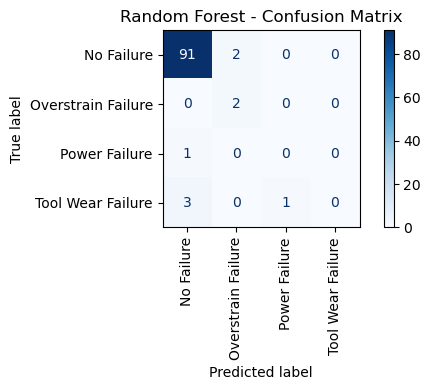


Random Forest - ROC AUC (OvR, macro): 0.6553

Per-class ROC AUC (OvR):
  No Failure: 0.7189
  Overstrain Failure: 0.9949
  Power Failure: 0.4646
  Tool Wear Failure: 0.4427


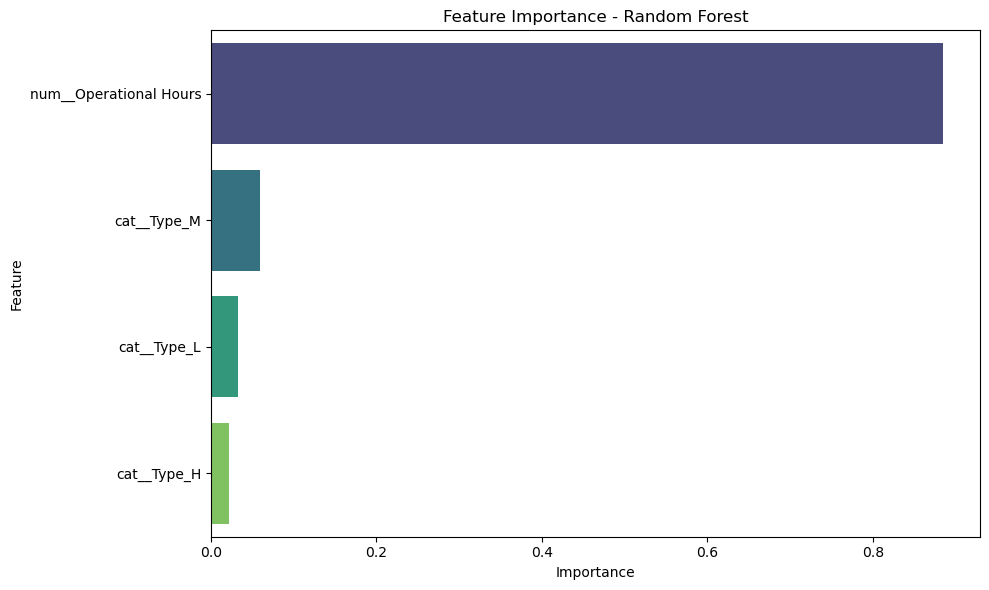


Top 10 Feature Importances:
                  Feature  Importance
0  num__Operational Hours    0.885408
3             cat__Type_M    0.059822
2             cat__Type_L    0.032806
1             cat__Type_H    0.021965


In [21]:
# 9. Detailed Evaluation of the Chosen Model
if final_model_pipeline:
    print(f"\n--- Detailed Evaluation for: {chosen_model_name} ---")
    y_pred_final = final_model_pipeline.predict(X_test)

    if y_test.empty or len(y_test) != len(y_pred_final):
        print("Error: y_test or y_pred_final issues. Cannot proceed with detailed evaluation.")
    else:
        print("\nClassification Report:")
        # Attempt to get classes from the model, fall back to y_test unique values
        try:
            model_classes = sorted(final_model_pipeline.named_steps['classifier'].classes_.astype(str))
        except (AttributeError, KeyError): # Handle if 'classifier' step missing or no 'classes_'
            model_classes = sorted(y_test.unique().astype(str))
        
        # Ensure all labels in y_test are covered by model_classes for confusion matrix
        # Or, use labels=np.unique(np.concatenate((y_test, y_pred_final))) for cm if there's mismatch
        # For classification_report, target_names should align with labels if provided.
        print(classification_report(y_test, y_pred_final, zero_division=0, labels=model_classes, target_names=model_classes))

        cm = confusion_matrix(y_test, y_pred_final, labels=model_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
        fig, ax = plt.subplots(figsize=(max(6, len(model_classes)), max(4, len(model_classes)*0.8)))
        disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
        plt.title(f"{chosen_model_name} - Confusion Matrix")
        plt.tight_layout()
        plt.show()

        if hasattr(final_model_pipeline, "predict_proba"):
            y_proba_final = final_model_pipeline.predict_proba(X_test)
            if len(model_classes) > 1 and y_proba_final.shape[1] == len(final_model_pipeline.classes_): # Check against pipeline's actual classes
                try:
                    # Use pipeline's classes for roc_auc_score labels
                    roc_auc_ovr = roc_auc_score(y_test, y_proba_final, multi_class='ovr', average='macro', labels=final_model_pipeline.classes_)
                    print(f"\n{chosen_model_name} - ROC AUC (OvR, macro): {roc_auc_ovr:.4f}")

                    print("\nPer-class ROC AUC (OvR):")
                    for i, class_label in enumerate(final_model_pipeline.classes_):
                        y_test_binarized_for_class = (y_test == class_label)
                        if np.sum(y_test_binarized_for_class) > 0 and np.sum(~y_test_binarized_for_class) > 0:
                             class_roc_auc = roc_auc_score(y_test_binarized_for_class, y_proba_final[:, i])
                             print(f"  {class_label}: {class_roc_auc:.4f}")
                        else:
                             print(f"  {class_label}: Not enough samples for ROC AUC.")
                except ValueError as e:
                    print(f"Could not calculate ROC AUC: {e}.")
            else:
                print("Warning: ROC AUC calculation skipped due to label/probability mismatch or single class.")
        else:
            print("Model does not support predict_proba, skipping ROC AUC.")

        final_classifier = final_model_pipeline.named_steps['classifier']
        if hasattr(final_classifier, 'feature_importances_'):
            preprocessor_step = final_model_pipeline.named_steps['preprocessor']
            try:
                transformed_feature_names = preprocessor_step.get_feature_names_out()
                importances = final_classifier.feature_importances_

                feature_imp_df = pd.DataFrame({
                    'Feature': transformed_feature_names,
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)

                plt.figure(figsize=(10, max(6, len(transformed_feature_names)*0.3)))
                sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
                plt.title(f'Feature Importance - {chosen_model_name}')
                plt.tight_layout()
                plt.show()
                print("\nTop 10 Feature Importances:")
                print(feature_imp_df.head(10))
            except Exception as e:
                print(f"Could not retrieve or plot feature importances: {e}")
else:
    print("Final model pipeline is not available. Skipping detailed evaluation.")

In [22]:
# 10. Save Model
if final_model_pipeline:
    joblib.dump(final_model_pipeline, MODEL_PATH)
    print(f"\nFull pipeline saved to: {MODEL_PATH}")
else:
    print("No model to save.")


Full pipeline saved to: electrical_failure_model.joblib


In [23]:
# 11. Example of Loading and Using the Saved Pipeline
print("\n--- Example: Load and Predict with Saved Full Pipeline ---")
if final_model_pipeline:
    try:
        loaded_full_pipeline = joblib.load(MODEL_PATH)
        print(f"Full pipeline loaded successfully from {MODEL_PATH}")

        if not X_test.empty:
            sample_raw_data_df = X_test.head(3).copy()
            print("\nSample raw data for prediction (first 3 from X_test, as DataFrame):")
            print(sample_raw_data_df)

            predictions = loaded_full_pipeline.predict(sample_raw_data_df)
            try:
                probabilities = loaded_full_pipeline.predict_proba(sample_raw_data_df)
            except AttributeError:
                probabilities = None
                print("predict_proba not available for this loaded pipeline/model.")

            print("\nPredictions for sample data:")
            for i, pred in enumerate(predictions):
                print(f"Sample {i+1}: Predicted Failure Category = {pred}")
                if probabilities is not None and i < len(probabilities):
                    try:
                        pred_class_idx = list(loaded_full_pipeline.classes_).index(pred)
                        print(f"  Confidence (Prob for {pred}): {probabilities[i, pred_class_idx]:.4f}")
                    except (ValueError, IndexError):
                        print(f"  Could not retrieve probability for class '{pred}'.")
        else:
            print("X_test is empty, cannot create sample data for prediction example.")

    except FileNotFoundError:
        print(f"Error: Model file {MODEL_PATH} not found.")
    except Exception as e:
        print(f"An error occurred during loading or prediction example: {e}")
else:
    print("Skipping loading example as no final model pipeline was available/trained.")

print("\n--- Notebook execution finished ---")


--- Example: Load and Predict with Saved Full Pipeline ---
Full pipeline loaded successfully from electrical_failure_model.joblib

Sample raw data for prediction (first 3 from X_test, as DataFrame):
     Operational Hours Type
399             129.87    L
372             120.30    M
143              39.11    H

Predictions for sample data:
Sample 1: Predicted Failure Category = No Failure
  Confidence (Prob for No Failure): 1.0000
Sample 2: Predicted Failure Category = No Failure
  Confidence (Prob for No Failure): 0.9700
Sample 3: Predicted Failure Category = No Failure
  Confidence (Prob for No Failure): 1.0000

--- Notebook execution finished ---
